# DataLab Cup 2: CNN for Object Detection
110065508 李丞恩

為了方便起見，我習慣把所有路徑/超參數放在第一個block，方便調整。

In [26]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# dataset params
DATA_PATH = './input/pascal_voc_training_data_copy.txt'#'./input/pascal_voc_training_data.txt'
IMAGE_DIR = './input/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 100

In [13]:
%matplotlib inline

import os
import cv2
import sys
import skimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from data_aug import *
from bbox_util import *
from PIL import Image

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-11-25 11:51:36.113125: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-25 11:51:36.143019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 11:51:36.143510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-11-25 11:51:36.143528: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-25 11:51:36.145210: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-25 11:51:36.145239: I tensorflow/stream_executor/pl

In [4]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [5]:
if not os.path.exists("output") : os.mkdir("output")
if not os.path.exists("model") : os.mkdir("model")

## 一. Data cleaning
### 1. Processed data format

In [6]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [7]:
training_data_file = open("./input/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


### 2. Generating the dataset
augmentation也在此時完成。我的計畫是把每種augmentation都生成另一個dataset。

In [8]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num, augmentation_type=0):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        #raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]
        
        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
        
        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
        #一定要加drop_remainder=True否則會有function call stack的error
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [35]:
def aug(data_path, catagory_prop):
    
    select_data = []
    # #################################
    input_file = open(data_path, 'r')
    p=1
    # #################################

    for line in input_file:
        line = line.strip()
        ss = line.split(' ')
        select_data.append(ss)
    #print(select_data)      
    with open("./input/oversample_training_data.txt", 'a') as f:
        
        for data in select_data :
            image_name = data[0]
            image_file = Image.open(IMAGE_DIR + image_name)
            image = np.array(image_file)
            box = np.reshape(data[1:] , (-1,5)).astype(np.int)
            classes = box[:,4]
            max_class = 20 #np.argmax(np.bincount(classes))
            #print(classes)
            
            if (len(np.bincount(classes)) > 14) and (np.bincount(classes)[14]) > 0:
                p = catagory_prop[14]
            else:
                p = catagory_prop[max_class]
                
            box = box.astype('float64')
            
            if random.random() < p :
                img_flip, bboxes_flip = RandomHorizontalFlip(1)(image.copy(), box.copy())
                bboxes_flip = bboxes_flip.flatten().astype(int)
                label = image_name[:-4]+ '_flip.jpg'
                
                for i in (bboxes_flip):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_flip)
                data.save(IMAGE_DIR + image_name[:-4]+ '_flip.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                # (-angle, angle) random rotate
                img_rotate, bboxes_rotate = RandomRotate(45)(image.copy(), box.copy())
                bboxes_rotate = bboxes_rotate.flatten().astype(int)
                label = image_name[:-4]+ '_rotate.jpg'
                
                for i in (bboxes_rotate):
                    label = label + ' '+str(i)
                    
                data = Image.fromarray(img_rotate)
                data.save(IMAGE_DIR + image_name[:-4]+ '_rotate.jpg')        
                f.writelines([label + '\n'])

            if random.random() < p :
                
                hue = 10*random.randint(1, 10)
                saturation = 10*random.randint(1, 10)
                brightness = 10*random.randint(1, 10)    
                
                img_HSV, bboxes_HSV = RandomHSV(hue, saturation, brightness)(image.copy(), box.copy())
                bboxes_HSV = bboxes_HSV.flatten().astype(int)
                label = image_name[:-4]+ '_hsv.jpg'
                
                for i in (bboxes_HSV):
                    label = label + ' '+str(i)

                data = Image.fromarray(img_HSV)
                data.save(IMAGE_DIR + image_name[:-4]+ '_hsv.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                img_shear, bboxes_shear = RandomShear(0.2)(image.copy(), box.copy())
                bboxes_shear = bboxes_shear.flatten().astype(int)
                label = image_name[:-4]+ '_shear.jpg'
                
                for i in (bboxes_shear):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_shear)
                data.save(IMAGE_DIR + image_name[:-4]+ '_shear.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                img_scale, bboxes_scale = RandomScale(0.2, diff = True)(image.copy(), box.copy())
                bboxes_scale = bboxes_scale.flatten().astype(int)
                label = image_name[:-4]+ '_scale.jpg'
                
                for i in (bboxes_scale):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_scale)
                data.save(IMAGE_DIR + image_name[:-4]+ '_scale.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                # pepper noise
                img_pepper = skimage.util.random_noise(image,mode="pepper",clip=True) * 255.0
                img_pepper = np.rint(img_pepper).astype(np.uint8)
                bboxes_pepper = box
                bboxes_pepper = bboxes_pepper.flatten().astype(int)
                label = image_name[:-4]+ '_pepper.jpg'

                for i in (bboxes_pepper):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_pepper)
                data.save(IMAGE_DIR + image_name[:-4]+ '_pepper.jpg')
                f.writelines([label + '\n'])
                
            if random.random() < p :
                # salt noise
                img_salt = skimage.util.random_noise(image,mode="salt",clip=True) * 255.0
                img_salt = np.rint(img_salt).astype(np.uint8)
                bboxes_salt = box
                bboxes_salt = bboxes_salt.flatten().astype(int)
                label = image_name[:-4]+ '_salt.jpg'

                for i in (bboxes_salt):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_salt)
                data.save(IMAGE_DIR + image_name[:-4]+ '_salt.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                # gaussian noise
                img_gaussian = skimage.util.random_noise(image,mode="gaussian",clip=True,mean=0,var=0.05) * 255.0
                img_gaussian = np.rint(img_gaussian).astype(np.uint8)
                bboxes_gaussian = box        
                bboxes_gaussian = bboxes_gaussian.flatten().astype(int)
                label = image_name[:-4]+ '_gaussian.jpg'

                for i in (bboxes_gaussian):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_gaussian)
                data.save(IMAGE_DIR + image_name[:-4]+ '_gaussian.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                # speckle noise
                img_speckle = skimage.util.random_noise(image,mode="speckle",clip=True,mean=0,var=0.05) * 255.0
                img_speckle = np.rint(img_speckle).astype(np.uint8)
                bboxes_speckle = box
                bboxes_speckle = bboxes_speckle.flatten().astype(int)
                label = image_name[:-4]+ '_speckle.jpg'

                for i in (bboxes_speckle):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_speckle)
                data.save(IMAGE_DIR + image_name[:-4]+ '_speckle.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                # salt & pepper noise
                img_saltpepper = skimage.util.random_noise(image,mode="s&p",clip=True,amount=0.1) * 255.0
                img_saltpepper = np.rint(img_saltpepper).astype(np.uint8)
                bboxes_saltpepper = box
                bboxes_saltpepper = bboxes_saltpepper.flatten().astype(int)
                label = image_name[:-4]+ '_saltpepper.jpg'

                for i in (bboxes_saltpepper):
                    label = label + ' '+str(i)
                data = Image.fromarray(img_saltpepper)
                data.save(IMAGE_DIR + image_name[:-4]+ '_saltpepper.jpg')
                f.writelines([label + '\n'])
                
            image_file.close()

In [21]:
def oversample(input_file):
    img_container = [[] for i in range(20)]
    oversample_data = []

    for line in input_file:
        line = line.strip()
        oversample_data.append(line)
        
        img_labels = line.split(" ")[5::5]
        img_labels_counter = np.zeros(20)  
        for i in img_labels:
            img_labels_counter[int(i)] += 1
        
        # to deal with the problem of large amount of human
        if img_labels_counter[14] > 0:
            img_container[14].append(line)
        else:
            img_container[np.argmax(img_labels_counter)].append(line)


    imgNum_of_class = [len(img) for img in img_container]
    threshold = max(imgNum_of_class) // 6
    
    sampled_data = []
    for i in range(20):
        if imgNum_of_class[i] < threshold :
            sampled_data.extend(random.choices(img_container[i], k = threshold - imgNum_of_class[i]))

    oversample_data.extend(sampled_data)
    
    with open('/input/oversample_training_data.txt', 'w') as f:
        for item in oversample_data:
            f.write("%s\n" % item)
            
##################################################

    oversample_file = open('/input/oversample_training_data.txt', 'r')
    
    img_container = [[] for i in range(20)]
    
    for line in oversample_file:
        line = line.strip()
        
        img_labels = line.split(" ")[5::5]
        img_labels_counter = np.zeros(20)  
        for i in img_labels:
            img_labels_counter[int(i)] += 1
        
        img_container[np.argmax(img_labels_counter)].append(line)

    imgNum_of_class = [len(img) for img in img_container]
    
    aug_probability = (np.max(imgNum_of_class) - imgNum_of_class) / imgNum_of_class / 10
    return aug_probability

In [19]:
class DatasetGenerator2:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list

        input_file = open(DATA_PATH, 'r')
        aug_probability = oversample(input_file)
        input_file.close()

        oversample_file = open("./input/oversample_training_data.txt",'r')
        aug(oversample_file , aug_probability)
        
        oversample_file.close()
        oversample_file = open("./input/oversample_training_data.txt",'r')
        for line in oversample_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        oversample_file.close()

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
#         image = preprocess_input(image)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [22]:
dataset = DatasetGenerator2().generate()

/tmp/ipykernel_3248417/3750588734.py:53: RuntimeWarning: divide by zero encountered in true_divide
  aug_probability = (np.max(imgNum_of_class) - imgNum_of_class) / imgNum_of_class / 10


FileNotFoundError: [Errno 2] No such file or directory: './input/oversample_training_data.txt'

In [56]:
print(dataset)

<PrefetchDataset shapes: ((8, 448, 448, 3), (8, 20, 5), (8,)), types: (tf.float32, tf.float32, tf.int32)>


## 二. 使用模型
### 1. Object Detection Model (YOLO)

In [9]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [10]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [11]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 192)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 192)       0      

### 2. Define loss
計算Intersection Over Union(IoU)

In [12]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [13]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [14]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

### 3. ResNet101

In [15]:
ResNet101 = tf.keras.Sequential([
    tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    layers.Flatten(),
    #layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x),
    #layers.LeakyReLU(0.1)(x),
    #Dropout(0.5),
    layers.Dense(1470)#, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
],
    name="ResNet101",
)
ResNet101.build((None, IMAGE_SIZE, IMAGE_SIZE, 3))

2021-11-25 11:08:54.725912: W tensorflow/core/common_runtime/bfc_allocator.cc:337] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-25 11:09:04.823000: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.20GiB (rounded to 2360279040)requested by op Add
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2021-11-25 11:09:04.823050: I tensorflow/core/common_ru

KeyboardInterrupt: 

In [ ]:
ResNet101.summary()

## 三. Model training

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

### 1. YOLO training

In [16]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3, checkpoint_name='yolo')

In [17]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

訓練的時候曾經遇到function call stack的error，後來發現是因為batch size無法整除dataset長度所致。在建立dataset的code增加一個參數就解決了，詳見第一大點最後一個block。

In [18]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-23 04:26:19.050801, start training.


2021-11-23 04:26:19.062442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 04:26:19.080355: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz
2021-11-23 04:26:23.833923: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-23 04:26:24.240143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-11-23 04:26:24.703265: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-23 04:26:24.703291: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-11-23 04:26:24.703665: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-23 04:26:24.703714: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

2021-11-23 04:28:20.481178, Epoch 1: loss 603.99


2021-11-23 04:28:20.669388: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 1: ./ckpts/YOLO/yolo-1
2021-11-23 04:30:14.852840, Epoch 2: loss 20.52


2021-11-23 04:30:15.040002: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 2: ./ckpts/YOLO/yolo-2
2021-11-23 04:32:09.353826, Epoch 3: loss 20.12


2021-11-23 04:32:09.542238: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 3: ./ckpts/YOLO/yolo-3
2021-11-23 04:34:03.973053, Epoch 4: loss 19.79


2021-11-23 04:34:04.163529: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 4: ./ckpts/YOLO/yolo-4
2021-11-23 04:35:58.617646, Epoch 5: loss 19.21


2021-11-23 04:35:58.808252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 5: ./ckpts/YOLO/yolo-5
2021-11-23 04:37:53.279214, Epoch 6: loss 18.68
Saved checkpoint for epoch 6: ./ckpts/YOLO/yolo-6
2021-11-23 04:39:47.859934, Epoch 7: loss 18.43
Saved checkpoint for epoch 7: ./ckpts/YOLO/yolo-7
2021-11-23 04:41:42.403398, Epoch 8: loss 18.29
Saved checkpoint for epoch 8: ./ckpts/YOLO/yolo-8
2021-11-23 04:43:37.002968, Epoch 9: loss 18.20
Saved checkpoint for epoch 9: ./ckpts/YOLO/yolo-9
2021-11-23 04:45:31.487090, Epoch 10: loss 18.01
Saved checkpoint for epoch 10: ./ckpts/YOLO/yolo-10
2021-11-23 04:47:26.013834, Epoch 11: loss 17.85
Saved checkpoint for epoch 11: ./ckpts/YOLO/yolo-11
2021-11-23 04:49:20.587084, Epoch 12: loss 17.64
Saved checkpoint for epoch 12: ./ckpts/YOLO/yolo-12
2021-11-23 04:51:15.057851, Epoch 13: loss 17.40
Saved checkpoint for epoch 13: ./ckpts/YOLO/yolo-13
2021-11-23 04:53:09.563827, Epoch 14: loss 17.14
Saved checkpoint for epoch 14: ./ckpts/YOLO/yolo-14
2021-11-23 04:55:04.172428, Epoch 15: loss 16.83
Save

Saved checkpoint for epoch 87: ./ckpts/YOLO/yolo-87
2021-11-23 07:14:23.894653, Epoch 88: loss 58.02
Saved checkpoint for epoch 88: ./ckpts/YOLO/yolo-88
2021-11-23 07:16:18.406776, Epoch 89: loss 53.19
Saved checkpoint for epoch 89: ./ckpts/YOLO/yolo-89
2021-11-23 07:18:12.836328, Epoch 90: loss 48.67
Saved checkpoint for epoch 90: ./ckpts/YOLO/yolo-90
2021-11-23 07:20:07.401077, Epoch 91: loss 44.96
Saved checkpoint for epoch 91: ./ckpts/YOLO/yolo-91
2021-11-23 07:22:01.892600, Epoch 92: loss 40.59
Saved checkpoint for epoch 92: ./ckpts/YOLO/yolo-92
2021-11-23 07:23:56.327249, Epoch 93: loss 37.57
Saved checkpoint for epoch 93: ./ckpts/YOLO/yolo-93
2021-11-23 07:25:50.789607, Epoch 94: loss 35.60
Saved checkpoint for epoch 94: ./ckpts/YOLO/yolo-94
2021-11-23 07:27:45.872748, Epoch 95: loss 33.67
Saved checkpoint for epoch 95: ./ckpts/YOLO/yolo-95
2021-11-23 07:29:40.755730, Epoch 96: loss 31.78
Saved checkpoint for epoch 96: ./ckpts/YOLO/yolo-96
2021-11-23 07:31:35.681491, Epoch 97: l

### 2. ResNet101 Training

In [15]:
ckpt_r101 = tf.train.Checkpoint(epoch=tf.Variable(0), net=ResNet101)
manager = tf.train.CheckpointManager(ckpt_r101, './ckpts/ResNet101', max_to_keep=3, checkpoint_name='resnet101')

In [16]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = ResNet101(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, ResNet101.trainable_weights)
    optimizer.apply_gradients(zip(grads, ResNet101.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt_r101.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt_r101.epoch), save_path))

## 四. Predict Test data
### 1. Process YOLO's predictions

In [19]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

### 2. Build Test dataset Iterator

In [20]:
test_img_files = open('./input/pascal_voc_testing_data.txt')
test_img_dir = './input/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [22]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-100')

In [23]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### 3. Make Prediction and Output to txt file

In [24]:
output_file = open('./output/test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), \
                                 xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" \
                          %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### 4. Run Evaluation Metric

In [25]:
sys.path.insert(0, './input/evaluate')
import evaluate
evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')

End Evalutation


### 5. ResNet101 prediction

In [26]:
@tf.function
def prediction_step_r101(img):
    return ResNet101(img, training=False)

In [ ]:
output_file = open('./output/test_prediction_ResNet101.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step_r101(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), \
                                 xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" \
                          %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
evaluate.evaluate('./output/test_prediction_ResNet101.txt', './output/output_file_ResNet101.csv')

## 五. Visualization
### 1. YOLO

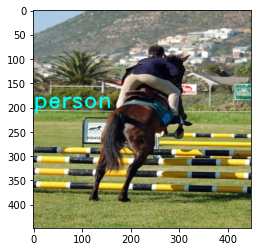

In [27]:
np_img = cv2.imread('./input/VOCdevkit_test/VOC2007/JPEGImages/000010.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

### 2. ResNet101

In [ ]:
y_pred = ResNet101(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()